In [43]:
import pandas as pd
import numpy as np
import nltk
import nltk.corpus
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
import pyodbc 
from sqlalchemy import create_engine
import re
import networkx as nx
import matplotlib.pyplot as plt
import string
import pymongo

In [44]:
nltk.download('stopwords')
stop_words.add('amp')

[nltk_data] Downloading package stopwords to /Users/sam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [45]:
# Set up Mongo database connection
client = pymongo.MongoClient()
db = client['GA_Runoffs']

# Create test userdata collection
requested_accounts = db['requested_accounts']
twitter_user_data = db['twitter_user_data']
collected_tweets = db['collected_tweets']

In [46]:
# Collect all posts with hashtag #demcastga

tweets = db.collected_tweets.find({"$text": {"$search":"#holdtheline"}}, {'entities.hashtags.tag':1,
                                                                              'category':1, 'username':1,
                                                                              'created_at':1, 'text':1,
                                                                            'author_id':1})

In [47]:
htl_tweets = pd.DataFrame(list(tweets))

In [48]:
len(htl_tweets)

17173

In [49]:
htl_tweets.head()

,_id,author_id,created_at,entities,text,category,username
0,5fee41e088da48afa84f82ba,1308745916325781511,2020-12-25T18:29:09.000Z,"{'hashtags': [{'tag': 'HoldTheLine'}, {'tag': ...",#HoldTheLine #HoldTheLine #HoldTheLine https:/...,holdtheline_ecosystem,NaN
1,5ff36dce93c05a63bd7a48b9,1343699976887693318,2021-01-01T02:10:41.000Z,{'hashtags': [{'tag': 'HoldTheLine'}]},#HoldTheLine,holdtheline_ecosystem,NaN
2,5ff36dbc93c05a63bd7a4605,909075262884732928,2021-01-01T14:07:05.000Z,{'hashtags': [{'tag': 'HoldTheLine'}]},#HoldTheLine,holdtheline_ecosystem,NaN
3,5ff36db693c05a63bd7a454c,22784232,2021-01-01T16:41:36.000Z,{'hashtags': [{'tag': 'HoldTheLine'}]},#HoldTheLine,holdtheline_ecosystem,NaN
4,5ff36da693c05a63bd7a42eb,1296140952902533120,2021-01-02T01:51:54.000Z,{'hashtags': [{'tag': 'HoldTheLine'}]},#HoldTheLine,holdtheline_ecosystem,NaN


In [50]:
htl_tweets[['created_at', 'text']].head(100)

,created_at,text
0,2020-12-25T18:29:09.000Z,#HoldTheLine #HoldTheLine #HoldTheLine https:/...
1,2021-01-01T02:10:41.000Z,#HoldTheLine
2,2021-01-01T14:07:05.000Z,#HoldTheLine
3,2021-01-01T16:41:36.000Z,#HoldTheLine
4,2021-01-02T01:51:54.000Z,#HoldTheLine
...,...,...
95,2020-12-26T01:19:16.000Z,@SenRickScott @SenateGOP Mitch Mcconnell - Why...
96,2020-12-26T01:19:33.000Z,@CIndyStarbuck @senatemajldr Mitch Mcconnell -...
97,2020-12-25T01:24:43.000Z,@FLOTUS @GOPChairwoman @POTUS #HoldTheLine !\n...
98,2020-12-26T00:01:25.000Z,@FLOTUS @GOPChairwoman @NoradSanta Mitch Mccon...


In [51]:
def clean_text(data):
  data = data.lower() #this may trigger a  warning...
  data = ' '.join([word for word in data.split(' ') if word not in stop_words])
  # data = ' '.join([word for word in data.split(' ') if word not in stopwords])
  data = data.encode('ascii', 'ignore').decode()
  data = re.sub(r'https*\S+', ' ', data)
  data = re.sub(r'@\S+', ' ', data)
  data = re.sub(r'#\S+', ' ', data)
  data = re.sub(r'\'\w+', '', data)
  data = re.sub('[%s]' % re.escape(string.punctuation), ' ', data)
  data = re.sub(r'\w*\d+\w*', '', data)
  data = re.sub(r'\s{2,}', ' ', data)
  data = ' '.join([word for word in data.split(' ') if word not in stop_words])
  # data = ' '.join([word for word in data.split(' ') if word not in stopwords])
  return data

In [52]:
htl_tweets['cleantext'] = htl_tweets['text'].apply(clean_text) 
htl_tweets = htl_tweets[htl_tweets['cleantext'].notnull()]
htl_tweets['cleantext'].reset_index(drop=True).head(20)

0      
1      
2      
3      
4      
5      
6      
7      
8      
9      
10     
11     
12     
13     
14     
15     
16     
17     
18     
19     
Name: cleantext, dtype: object

In [53]:
htl_tweets['cleantext'].reset_index(drop=True).head(100)

0                                                      
1                                                      
2                                                      
3                                                      
4                                                      
                            ...                        
95     mitch mcconnell fight ga runoff republican ma...
96     mitch mcconnell fight ga runoff republican ma...
97     coward wh advisors never trump snobs block pr...
98     mitch mcconnell fight ga runoff republican ma...
99     mitch mcconnell fight ga runoff republican ma...
Name: cleantext, Length: 100, dtype: object

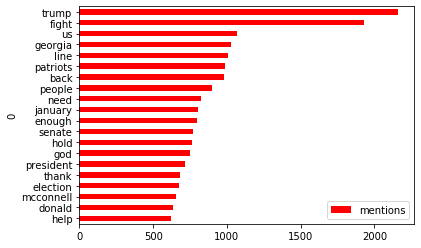

In [54]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(htl_tweets['cleantext'], 20)
#for word, freq in common_words:
#    print(word, freq)
common_words_df = pd.DataFrame(common_words)
fig, ax = plt.subplots()
common_words_df.plot.barh(x=0, y=1, color='r', ax=ax).invert_yaxis()
ax.legend(["mentions"])

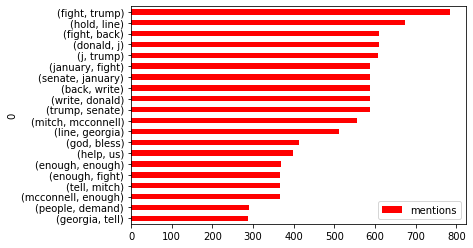

In [55]:
bigrams = [(x, i.split()[j + 1]) for i in htl_tweets['cleantext']  
       for j, x in enumerate(i.split()) if j < len(i.split()) - 1]
frequency_dist_bigrams = FreqDist(bigrams)
common_bigrams_df = pd.DataFrame(frequency_dist_bigrams.most_common(20))
fig, ax = plt.subplots()
common_bigrams_df.plot.barh(x=0, y=1, color='r', ax=ax).invert_yaxis()
ax.legend(["mentions"]);

In [56]:

# Only alphabet, contains at least 3 letters, and appears > 10 times in the text
vectorizer = CountVectorizer(analyzer='word', 
                              token_pattern=r'\b[a-zA-Z]{3,}\b',  
                              ngram_range=(1, 1),
                              min_df=10)
count_vectorized = vectorizer.fit_transform(htl_tweets['cleantext'])
tfidf_transformer = TfidfTransformer(smooth_idf=True, use_idf=True)
vectorized = tfidf_transformer.fit_transform(count_vectorized)
vector_matrix = pd.DataFrame(vectorized.toarray(), 
             index=['message '+str(i) 
                    for i in range(1, 1+len(htl_tweets['cleantext']))],
             columns=vectorizer.get_feature_names())

In [57]:
pairwise_cov_matrix = vector_matrix.cov()

In [58]:
pairwise_cor = np.corrcoef(pairwise_cov_matrix)
words = list(pairwise_cov_matrix.columns) 
pairwise_cor_matrix = pd.DataFrame(pairwise_cor, columns = words, index = words)

In [59]:
def corr_network(matrix, topics, words):
    temp_mat = matrix[matrix.index.isin(topics)]
    temp_df = pd.DataFrame(temp_mat.T.unstack().reset_index(name='correlation').sort_values('correlation', ascending=False))
    temp_df = temp_df.rename(columns={"level_0": 'topic', "level_1": 'word'})
    temp_df = temp_df.sort_values(['topic','correlation'], ascending=False).reset_index(drop=True)
    temp_df = temp_df[temp_df['topic'] != temp_df['word']]
    return temp_df.groupby(['topic'],as_index=False).apply(lambda x: x.nlargest(words, 'correlation'))

pairwise_cor_network = corr_network(pairwise_cor_matrix, common_words_df[0], 10)

In [63]:
pairwise_cor_network[pairwise_cor_network['topic'] == 'warnock']

,,topic,word,correlation


/Users/sam/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


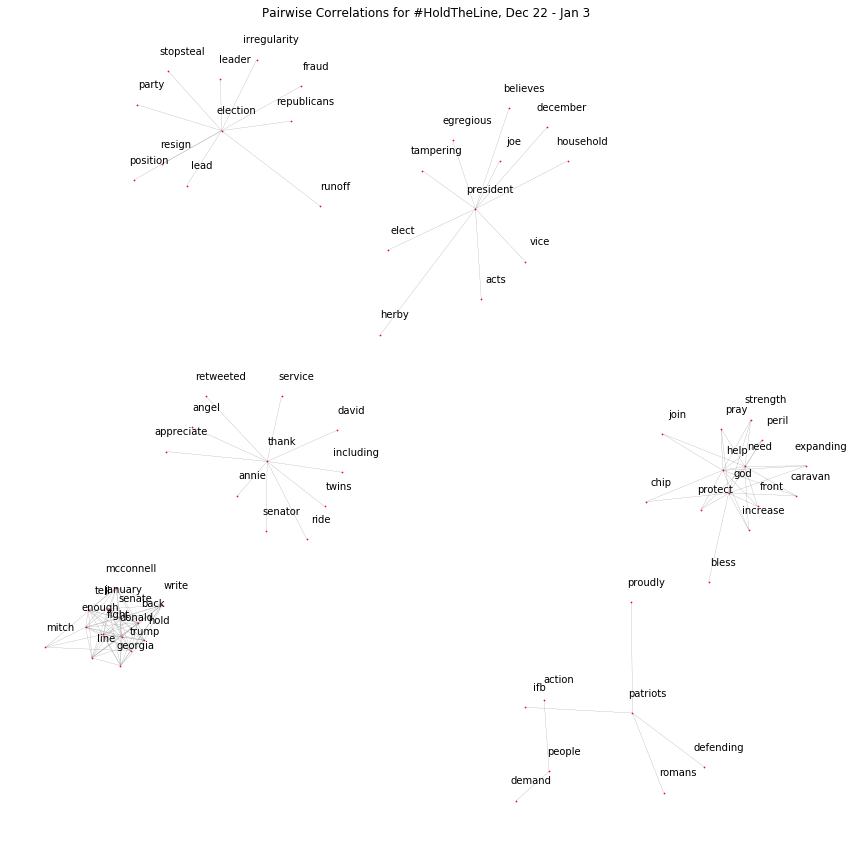

In [70]:
np.random.seed(2020)
pairwise_cor_network_clean = pairwise_cor_network[pairwise_cor_network['correlation'] > 0.25]
G = nx.from_pandas_edgelist(pairwise_cor_network_clean, source='word', target='topic', edge_attr=True)
fig, ax = plt.subplots(figsize=(15, 15))

#pos = nx.spring_layout(G, k=10/G.order())
#pos = nx.spiral_layout(G)
pos = nx.fruchterman_reingold_layout(G, k=20/G.order())
#pos = nx.kamada_kawai_layout(G)
#pos = nx.spectral_layout(G)
# Plot networks
nx.draw_networkx(G, pos,
                 font_size=8,
                 width=0.2,
                 node_size = 0.5,
                 edge_color='grey',
                 node_color='red',
                 with_labels = False,
                 ax=ax)

# Create offset labels
for key, value in pos.items():
    x, y = value[0]+.035, value[1]+.045
    ax.text(x, y,
            s=key,
            #bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=10)
    
plt.axis('off')
plt.title("Pairwise Correlations for #HoldTheLine, Dec 22 - Jan 3")
plt.savefig('holdtheline_tweets.pdf', dpi=300, bbox_inches="tight")

In [12]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'amp',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'o

In [69]:
plt.savefig('holdtheline_tweets.pdf', dpi=300, bbox_inches="tight")

<Figure size 432x288 with 0 Axes>